In [4]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import folium
from folium import plugins
from sklearn.cluster import DBSCAN

In [8]:
path = "ds"
files = {'customers'    : path+'/olist_customers_dataset.csv',
         'geolocation'  : path+'/olist_geolocation_dataset.csv',
         'items'        : path+'/olist_order_items_dataset.csv',
         'payment'      : path+'/olist_order_payments_dataset.csv',
         'orders'       : path+'/olist_orders_dataset.csv',
         'products'     : path+'/olist_products_dataset.csv',
         'sellers'      : path+'/olist_sellers_dataset.csv',
         'review'       : path+'/olist_order_reviews_dataset.csv',
         }

dfs = {}
for key, value in files.items():
    dfs[key] = pd.read_csv(value)

In [9]:
# Cruzamento gradativo
customers_location = dfs['customers'].merge(dfs['geolocation'], how='inner', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix').drop_duplicates('customer_id', keep='first')
cusloc_order = customers_location.merge(dfs['orders'], how='inner', on='customer_id')
cuslocord_item = cusloc_order.merge(dfs['items'], how='inner', on='order_id')
cuslocordite_prod = cuslocord_item.merge(dfs['products'], how='inner', on='product_id')
cuslocordite_rev= cuslocordite_prod.merge(dfs['review'], how='left', on='order_id')

# Selecionando as colunas de interesse
final = cuslocordite_rev[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state',
       'geolocation_lat', 'geolocation_lng','order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_photos_qty',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp']]

# Convertendo para datetime
datas = ['order_purchase_timestamp'
        ,'order_purchase_timestamp'
        ,'order_delivered_carrier_date'
        ,'order_delivered_customer_date'
        ,'order_estimated_delivery_date'
        ,'shipping_limit_date'
        ,'review_creation_date'
        ,'review_answer_timestamp'
        ]

for data in datas:
    final[data] = pd.to_datetime(final[data])

# Criando coluna de tempo de entrega e Hora da compra
final['delivery_time'] = final['order_delivered_customer_date'] - final['order_purchase_timestamp']

# Seleção do período de interesse
final = final[(final['order_purchase_timestamp'].dt.year > 2016)
              &
              (final['order_purchase_timestamp'] < pd.to_datetime('20180901'))
             ]
final = final.reset_index(drop=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112632 entries, 0 to 112631
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   customer_id                    112632 non-null  object         
 1   customer_unique_id             112632 non-null  object         
 2   customer_zip_code_prefix       112632 non-null  int64          
 3   customer_city                  112632 non-null  object         
 4   customer_state                 112632 non-null  object         
 5   geolocation_lat                112632 non-null  float64        
 6   geolocation_lng                112632 non-null  float64        
 7   order_id                       112632 non-null  object         
 8   order_status                   112632 non-null  object         
 9   order_purchase_timestamp       112632 non-null  datetime64[ns] 
 10  order_approved_at              112617 non-null  object  

Gráfico I


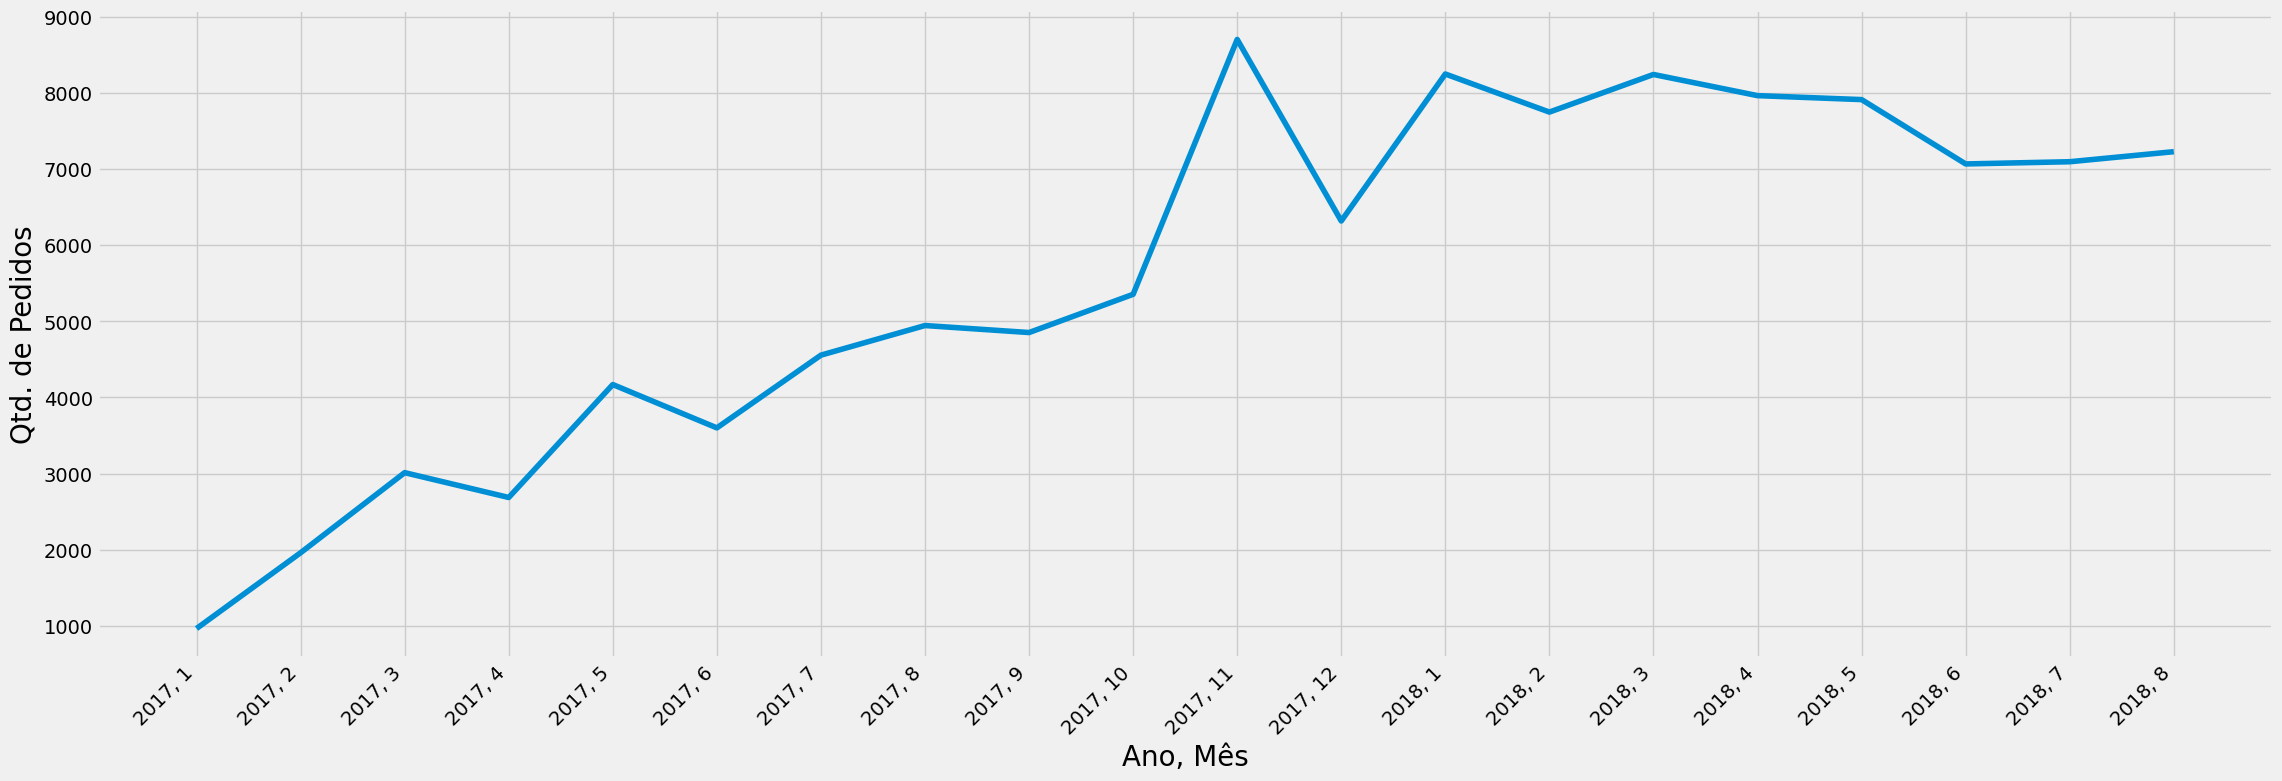

In [10]:
meses_compras = pd.DataFrame()
meses_compras['mes'] = final['order_purchase_timestamp'].dt.month
meses_compras['ano'] = final['order_purchase_timestamp'].dt.year
meses_compras['count'] = final['customer_id']
meses_compras = meses_compras.groupby(['ano','mes'])['count'].count().reset_index()
meses_compras['ano_mes'] = meses_compras['ano'].astype(str) + ', ' + meses_compras['mes'].astype(str)

plt.figure(figsize=(25,8))
plt.plot(meses_compras['ano_mes'], meses_compras['count'])
plt.xlabel('Ano, Mês', size=20)
plt.ylabel('Qtd. de Pedidos', size=20)
plt.xticks(meses_compras.index[::1], meses_compras['ano_mes'][::1], rotation=45, ha='right') # Select every other tick

print(r'Gráfico I')
plt.show()

In [11]:
estado_compras = final.groupby('customer_state', as_index=False)['price'].sum().sort_values(by='customer_state')
estado_compras_med = final.groupby('customer_state', as_index=False)['price'].mean().sort_values(by='customer_state')
frete_medio = final.groupby('customer_state', as_index=False)['freight_value'].mean().sort_values(by='customer_state')

print('Tabela 1')
estado_compras_med['price'].describe()

Tabela 1


count    27.00
mean    145.19
std      21.18
min     109.55
25%     124.64
50%     145.06
75%     158.72
max     189.98
Name: price, dtype: float64

Gráfico II


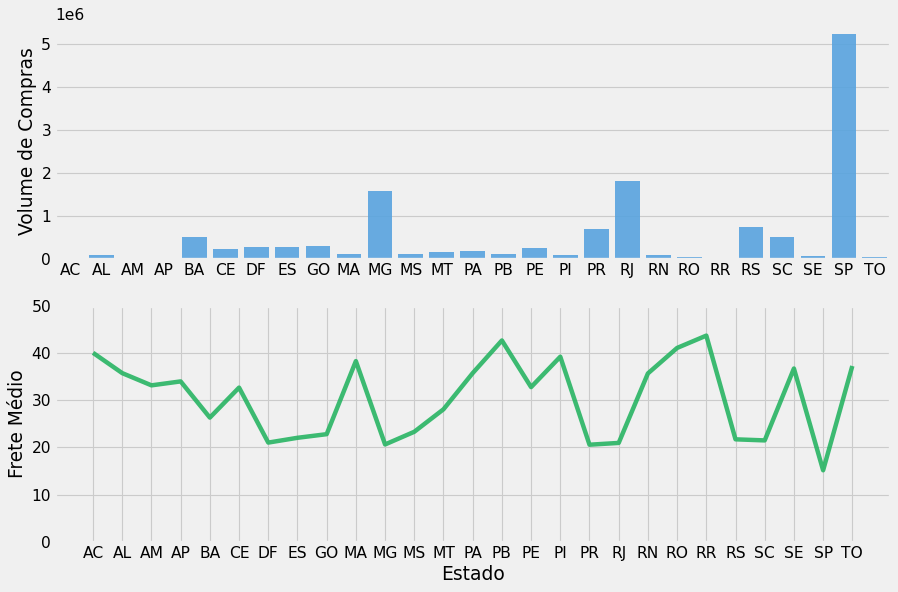

In [12]:
figure(num=None, figsize=(12, 8), dpi=80)

plt.subplot(2, 1, 1)
sns.barplot(x=estado_compras['customer_state'], y=estado_compras['price'], color='#42A5F5', alpha=0.9)
plt.xlabel(None)
plt.ylabel('Volume de Compras')

plt.subplot(2, 1, 2)
sns.lineplot(x=frete_medio['customer_state'], y=frete_medio['freight_value'], color='#28B463', alpha=0.9)
#ylim(top=3)  # adjust the top leaving bottom unchanged
plt.ylim(0,50)
plt.xlabel('Estado')
plt.ylabel('Frete Médio')

print(r'Gráfico II')
plt.show()

Gráfico III


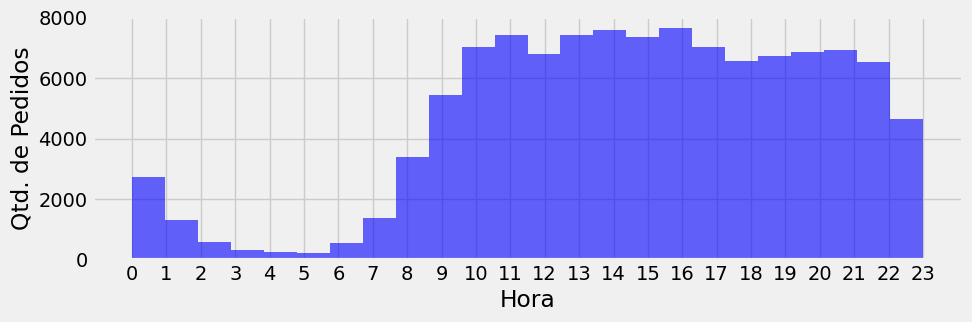

In [13]:
# Criação da coluna com o valor referente às Horas
final['purchase_hour'] = final['order_purchase_timestamp'].dt.hour

figure(num=None, figsize=(10, 3), dpi=100)
plt.hist(final['purchase_hour'], bins=24, facecolor='b', alpha=0.6)
plt.xticks(ticks=np.arange(24))
plt.xlabel('Hora')
plt.ylabel('Qtd. de Pedidos')

print(r'Gráfico III')
plt.show()

In [14]:
#Seleção de informações agrupadas pelo consumidor
cus_valor = final.groupby('customer_unique_id', as_index=False)['price'].sum() #price_x
cus_qtd = final.groupby('customer_unique_id', as_index=False)['price'].count() #price_y
cus_frete = final.groupby('customer_unique_id', as_index=False)['freight_value'].sum()
cus_loc = final[['customer_unique_id', 'geolocation_lat', 'geolocation_lng', 'customer_state']].drop_duplicates('customer_unique_id')
cus_review = final.groupby('customer_unique_id', as_index=False)['review_score'].mean()

#União das informações em um Dataframe
customer = cus_valor.merge(cus_qtd, on='customer_unique_id')
customer = customer.merge(cus_frete, on='customer_unique_id')
customer = customer.merge(cus_loc, on='customer_unique_id')
customer = customer.merge(cus_review, on='customer_unique_id')
customer = customer.rename(columns={'price_x':'price', 'price_y':'count_items'})

print('Média do valor de compra: R$ ' + str(round(customer['price'].mean(),2)) + '\nDesvio Padrão: R$ ' + str(round(customer['price'].std(),2)))
customer.sort_values(by='price', ascending=False).head(10)

Média do valor de compra: R$ 142.99
Desvio Padrão: R$ 218.95


,customer_unique_id,price,count_items,freight_value,geolocation_lat,geolocation_lng,customer_state,review_score
3772,0a0a92112bd4c708ca5fde585afaa872,13440.00,8,224.08,-22.90,-43.18,RJ,1.00
80906,da122df9eeddfedc1dc1f5349a1a690c,7388.00,2,183.63,-22.87,-42.27,RJ,5.00
43891,763c8b1c9c68a0229c42c9fc6f662b93,7160.00,4,114.88,-20.38,-40.31,ES,1.00
81746,dc4802a71eae9be1dd28f5d788ceb526,6735.00,1,194.31,-20.50,-54.57,MS,5.00
25865,459bef486812aa25204be022145caa62,6729.00,1,193.21,-20.27,-40.28,ES,NaN
94572,ff4159b92c40ebe40454e3e6a7c35ed6,6499.00,1,227.66,-22.21,-49.95,SP,5.00
23805,4007669dec559734d6f53e029e360987,5934.60,6,146.94,-20.16,-44.88,MG,1.00
88532,eebb5dda148d3893cdaf5b5ca3040ccb,4690.00,1,74.34,-23.68,-46.42,SP,4.00
34622,5d0a2980b292d049061542014e8960bf,4599.90,2,209.54,-16.69,-49.28,GO,1.00
27084,48e1ac109decbb87765a3eade6854098,4590.00,1,91.78,-7.10,-34.84,PB,5.00


In [15]:
a = final[['customer_unique_id','review_score', 'review_comment_message']][
    (final['customer_unique_id'] == '0a0a92112bd4c708ca5fde585afaa872')
    |(final['customer_unique_id'] == '763c8b1c9c68a0229c42c9fc6f662b93')
    |(final['customer_unique_id'] == '459bef486812aa25204be022145caa62')]
print('Comentários por parte dos consumidores que pontuarão a avaliação com nota 1.00')
print('')

grouped_comments = a.groupby('customer_unique_id')['review_comment_message'].min()

for i, (customer_id, comment) in enumerate(grouped_comments.items()):
    if pd.notna(comment):
        print(f'CONSUMIDOR {i+1}: {comment}')
    else:
        print(f'CONSUMIDOR {i+1}: No review comment available')

Comentários por parte dos consumidores que pontuarão a avaliação com nota 1.00

CONSUMIDOR 1: Peço por favor verificar a entrega do pedido, pois não recebemos.
CONSUMIDOR 2: No review comment available
CONSUMIDOR 3: Comprei 04 unidades, e foram entregues apenas 02 pacotes com 01 unidade cada. Ainda não sei se serão entregues as outras 02 unidades faltantes.
De qualquer forma, a entrega deve ser de uma única vez.


In [16]:
# Selecionando dados do Distrito Federal e uma amostra de 1000 consumidores
customer_df = customer[customer['customer_state'] == 'DF']
customer_df = customer_df.sample(1000, random_state=1223)

Clus_dataSet = customer_df[['geolocation_lat','geolocation_lng']]

db = DBSCAN(eps=0.015, min_samples=50).fit(Clus_dataSet)
labels = db.labels_
customer_df["Clus_Db"]=labels

# A sample of clusters
print('Clusters formados:')
customer_df["Clus_Db"].value_counts()

Clusters formados:


Clus_Db
-1    630
 1    132
 3     95
 2     74
 0     69
Name: count, dtype: int64

In [17]:
# Visualização gráfica
map_clusters = folium.Map(location=[-15.89, -47.9], zoom_start=11)
rainbow = ['#CD5C5C','#7B68EE','#FF8C00','#8B4513','#008B8B','#FF69B4']
print(' Cluster -1: Ciano\n','Cluster  0: Rosa\n','Cluster  1: Vermelho\n','Cluster  2: Azul\n','Cluster  3: Laranja\n','Cluster  4: Marrom')
# add markers to the map
markers_colors = []
for lat, lon, price, cluster in zip(customer_df['geolocation_lat'], customer_df['geolocation_lng'], customer_df['price'], customer_df['Clus_Db']):
    label = folium.Popup('R$ ' + str(price) + ' \(Cluster ' + str(cluster) + '\)', parse_html=True, max_width=150,min_width=100)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

 Cluster -1: Ciano
 Cluster  0: Rosa
 Cluster  1: Vermelho
 Cluster  2: Azul
 Cluster  3: Laranja
 Cluster  4: Marrom


In [ ]:
# Agrupamento por Região encontrada na clusterização
customer_df['Região'] = customer_df['Clus_Db'].replace({-1:'Outras Satélites'
                                                       ,0:'Águas Claras'
                                                       ,1:'Asa Norte'
                                                       ,2:'Asa Sul'
                                                       ,3:'Guará'
                                                       ,4:'Cruzeiro'
                                                       })

print('Valor médio de compras:')
customer_df.groupby('Região')['price'].mean().sort_values(ascending=False)

Valor médio de compras:


,price
Região,
Asa Sul,201.74
Águas Claras,166.72
Outras Satélites,140.42
Asa Norte,140.29
Guará,131.25
